### Aleksandr Belov

# Homework 2, *part 2*
### (60 points total)

In this part, you will build a convolutional neural network (CNN) to solve (yet another) image classification problem: the Tiny ImageNet dataset (200 classes, 100K training images, 10K validation images). Try to achieve as high accuracy as possible.

**Unlike part 1**, you are now free to use the full power of PyTorch and its subpackages.

## Deliverables

* This file.
* A "checkpoint file" `"checkpoint.pth"` that contains your CNN's weights (you get them from `model.state_dict()`). Obtain it with `torch.save(..., "checkpoint.pth")`. When grading, we will load it to evaluate your accuracy.

**Should you decide to put your `"checkpoint.pth"` on Google Drive, update (edit) the following cell with the link to it:**

### [Dear TAs, I've put my "checkpoint.pth" on Google Drive, download it here](https://drive.google.com/drive/folders/1LxgGEg6p-aaFP-68R9YjK38WNtGN_sM6?usp=sharing)

## Grading

* 9 points for reproducible training code and a filled report below.
* 11 points for building a network that gets above 25% accuracy.
* 4 points for using an **interactive** (please don't reinvent the wheel with `plt.plot`) tool for viewing progress, for example Tensorboard ([with this library](https://github.com/lanpa/tensorboardX) and [an extra hack for Colab](https://stackoverflow.com/a/57791702)). In this notebook, insert screenshots of accuracy and loss plots (training and validation) over iterations/epochs/time.
* 6 points for beating each of these accuracy milestones on the private **test** set:
  * 30%
  * 34%
  * 38%
  * 42%
  * 46%
  * 50%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves, reporting your accuracy in a comment to the grade.

Note that there is an important formatting requirement, see below near "`DO_TRAIN = True`".

## Restrictions

* No pretrained networks.
* Don't enlarge images (e.g. don't resize them to $224 \times 224$ or $256 \times 256$).

## Tips

* **One change at a time**: never test several new things at once (unless you are super confident). Train a model, introduce one change, train again.
* Google a lot: try to reinvent as few wheels as possible (unlike in part 1 of this assignment).
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation...
* Pay much attention to accuracy and loss graphs (e.g. in Tensorboard). Track failures early, stop bad experiments early.

In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

The below cell puts training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:

In [0]:
# Extract the dataset into the current directory
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()

**You are required** to format your notebook cells so that `Run All` on a fresh notebook:
* trains your model from scratch, if `DO_TRAIN is True`;
* loads your trained model from `"./checkpoint.pth"`, then **computes** and prints its validation accuracy, if `DO_TRAIN is False`.

In [0]:
DO_TRAIN = True

## Train the model

In [0]:
# Your code here (feel free to add cells)
import os
from time import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import (Compose, RandomRotation, ToTensor,
                                    RandomResizedCrop, RandomHorizontalFlip,
                                    ColorJitter, Normalize, CenterCrop, ToPILImage
                                   )

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

def one_hot_encode(labels, n_classes):
    labels_reshaped = labels.view(len(labels), -1)
    ohe_labels = torch.zeros(len(labels), n_classes)
    ohe_labels.scatter_(1, labels_reshaped, 1)
    
    return ohe_labels


def compute_accuracy(model, data_loader):
    scores = []
    model.eval()
    n_images = 0

    for X, y in data_loader:
        pred = model(X)
        y_pred = pred.argmax(dim=1)
        num_of_true_pred = torch.sum((y_pred == y).type(torch.float32))
        scores.append(num_of_true_pred)

        n_images += len(X)

    return 100 * sum(scores) / n_images


def calculate_mean_std():
    batch_size = 1000

    folder_loader = ImageFolder(PATH_TO_TRAIN_DATA, ToTensor())
    simple_train_loader = DataLoader(folder_loader, batch_size=batch_size, num_workers=4)

    means = torch.zeros(3, dtype=torch.float32)
    stds = torch.zeros(3, dtype=torch.float32)

    for X, y in simple_train_loader:

        means += X.mean(dim=(0, 2, 3))
        stds += X.std(dim=(0, 2, 3))

    means /= NUM_OF_TRAIN_IMAGES // batch_size
    stds /= NUM_OF_TRAIN_IMAGES // batch_size

    print('Channelwise mean:', means)
    print('Channelwise std:', stds)

In [0]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

#         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2),

#         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2),

        Flatten(),
        nn.Dropout(0.3),

        nn.Linear(256 * (64 // 32) ** 2, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),

        nn.Linear(1024, 200),
        nn.LogSoftmax(dim=1)
    )
    return model

In [0]:
def train_step(net, train_loader, criterion, optimizer, epoch, writer):
    train_losses = []
    scores = []
    net.train()

    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        pred = net(X)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        y_pred = pred.argmax(dim=1)
        num_of_true_pred = torch.sum((y_pred == y).type(torch.float32))
        scores.append(num_of_true_pred)

    loss = sum(train_losses) / len(train_losses)
    score = 100 * sum(scores) / NUM_OF_TRAIN_IMAGES
        
    writer.add_scalar('loss', loss, epoch)
    writer.add_scalar('accuracy', score, epoch)

    return loss, score


def eval(net, val_loader, criterion, epoch, writer):
    val_losses = []
    scores = []
    net.eval()

    for i, (X, y) in enumerate(val_loader):
        X = X.to(device)
        y = y.to(device)

        pred = net(X)
        loss = criterion(pred, y)
        val_losses.append(loss.item())

        y_pred = pred.argmax(dim=1)
        num_of_true_pred = torch.sum((y_pred == y).type(torch.float32))
        scores.append(num_of_true_pred)

    loss = sum(val_losses) / len(val_losses)
    score = 100 * sum(scores) / NUM_OF_VAL_IMAGES

    writer.add_scalar('loss', loss, epoch)
    writer.add_scalar('accuracy', score, epoch)

    return loss, score


def train(epochs, net, criterion, optimizer, train_loader, val_loader,
          scheduler=None, verbose=True, save_dir=None, log_file=None, board_dir=None):

    print(f'Model dir: {save_dir}', end='\n\n')

    net.to(device)
    best_val_score = 0
    
    writer_train = SummaryWriter(os.path.join(board_dir, 'train'))
    writer_val = SummaryWriter(os.path.join(board_dir, 'val'))
    

    for epoch in range(1, epochs+1):
        t = time()
        train_loss, train_score = train_step(net, train_loader, criterion, optimizer, epoch, writer_train)
        val_loss, val_score = eval(net, val_loader, criterion, epoch, writer_val)

        if scheduler is not None:
            scheduler.step()

        if save_dir and best_val_score < val_score:
            best_val_score = val_score
            path_to_model = os.path.join(save_dir, f'cp_{val_score*100:.0f}.pth')
            path_to_best_model = os.path.join(save_dir, 'best_model.pth')
            torch.save(net.state_dict(), path_to_model)
            torch.save(net.state_dict(), path_to_best_model)

        lr = optimizer.param_groups[0]['lr']
        log_line =  f'{epoch}/{epochs} || LR: {lr:.5f} | ' + \
                    f'Train:  Loss {train_loss:.4f} Score: {train_score:.4f} || ' + \
                    f'Val: Loss {val_loss:.4f} Score: {val_score:.4f} || {time()-t:.1f} sec'

        if verbose:
            print(log_line)

        if log_file:
            with open(log_file, 'a') as f:
                f.write(log_line + '\n')

In [0]:
PATH_TO_TRAIN_DATA = 'tiny-imagenet-200/train'
PATH_TO_VAL_DATA = 'tiny-imagenet-200/val'
PATH_TO_MODELS = 'models'

RANDOM_STATE = 42
NUM_OF_TRAIN_IMAGES = 100000
NUM_OF_VAL_IMAGES = 10000

In [0]:
os.makedirs(PATH_TO_MODELS, exist_ok=True)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [0]:
%%time

calculate_mean_std()

Channelwise mean: tensor([0.4802, 0.4481, 0.3975])
Channelwise std: tensor([0.2745, 0.2672, 0.2784])
CPU times: user 24.8 s, sys: 2.47 s, total: 27.2 s
Wall time: 13.8 s


In [0]:
torch.manual_seed(RANDOM_STATE)

train_transformer = Compose([ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
                             RandomHorizontalFlip(0.3),
                             RandomRotation(15),
                             #CenterCrop((60, 60)),
                             #RandomResizedCrop((64, 64), scale=(0.8, 1)),
                             ToTensor(),
                             Normalize([0.4802, 0.4481, 0.3975],
                                       [0.2745, 0.2672, 0.2784]
                                      )
                            ])

val_transformer = Compose([ToTensor(),
                           Normalize([0.4802, 0.4481, 0.3975],
                                     [0.2745, 0.2672, 0.2784]
                                    )
                          ])

train_dataset = ImageFolder(PATH_TO_TRAIN_DATA, train_transformer)
val_dataset = ImageFolder(PATH_TO_VAL_DATA, val_transformer)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

tensor([-0.1663, -0.1488, -0.1390]) tensor([1.0390, 1.0450, 1.0244])


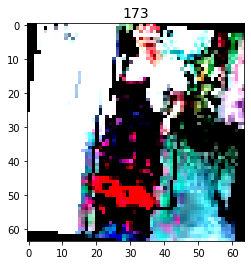

In [0]:
for x, y in train_loader:
   #vminx[0].numpy().min())

    print(x.mean((0, 2, 3)), x.std((0, 2, 3)))
    plt.imshow(x[0].transpose(0, 2).transpose(0, 1).numpy())
    plt.title(f'{y[0]}', fontsize=14)
    break

In [0]:
if DO_TRAIN:
    # Your code here (train your model)
    # etc.
    torch.manual_seed(RANDOM_STATE)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    model = make_model()
    criterion = nn.NLLLoss()
    optimizer = Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
    scheduler = MultiStepLR(optimizer, (10, 20, 30), gamma=0.2) # StepLR(optimizer, 5, 0.9)

Device: cuda:0


In [0]:
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters: 2809544


In [0]:
if DO_TRAIN:
    model_name = 'test_6/'
    save_dir = os.path.join(PATH_TO_MODELS, model_name)
    log_file = os.path.join(save_dir, 'log')
    os.makedirs(save_dir, exist_ok=True)

    with open(log_file, 'a') as f:
        f.write(str(train_transformer) + '\n\n')
        f.write(str(model) + '\n\n')
        f.write(str(optimizer) + '\n\n')
        f.write(str())

    epochs = 20

    board_dir = os.path.join('runs', model_name)

In [0]:
%%time

if DO_TRAIN:
    train(epochs, model, criterion, optimizer, train_loader, val_loader, 
          scheduler, save_dir=save_dir, log_file=log_file, board_dir=board_dir)

Model dir: models/test_6/

1/20 || LR: 0.00200 | Train:  Loss 4.1525 Score: 12.4190 || Val: Loss 3.6561 Score: 18.7800 || 106.3 sec
2/20 || LR: 0.00200 | Train:  Loss 3.3535 Score: 23.8600 || Val: Loss 3.2577 Score: 25.6400 || 106.0 sec
3/20 || LR: 0.00200 | Train:  Loss 2.9972 Score: 30.1580 || Val: Loss 2.9488 Score: 31.3100 || 105.9 sec
4/20 || LR: 0.00200 | Train:  Loss 2.7421 Score: 34.7900 || Val: Loss 2.7922 Score: 33.9000 || 105.8 sec
5/20 || LR: 0.00200 | Train:  Loss 2.5492 Score: 38.5900 || Val: Loss 2.6426 Score: 36.8500 || 105.7 sec
6/20 || LR: 0.00200 | Train:  Loss 2.3867 Score: 41.5950 || Val: Loss 2.5531 Score: 39.3700 || 105.7 sec
7/20 || LR: 0.00200 | Train:  Loss 2.2535 Score: 44.3510 || Val: Loss 2.5073 Score: 40.2700 || 105.9 sec
8/20 || LR: 0.00200 | Train:  Loss 2.1359 Score: 46.7300 || Val: Loss 2.4768 Score: 41.4800 || 105.9 sec
9/20 || LR: 0.00200 | Train:  Loss 2.0338 Score: 48.6920 || Val: Loss 2.4082 Score: 43.0500 || 105.6 sec
10/20 || LR: 0.00040 | Train

## Load and evaluate the model

In [0]:
# Please change it if necessary
PATH_TO_TEST_DATA = 'tiny-imagenet-200/val'

test_transformer = Compose([ToTensor(),
                           Normalize([0.4802, 0.4481, 0.3975],
                                     [0.2745, 0.2672, 0.2784]
                                    )
                          ])

test_dataset = ImageFolder(PATH_TO_TEST_DATA, test_transformer)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=4)

In [0]:
# Your code here (load the model from "./checkpoint.pth")
# Please use `torch.load("checkpoint.pth", map_location='cpu')`

In [0]:
model = make_model()
model_params = torch.load('checkpoint.pth', map_location='cpu')
model.load_state_dict(model_params)
model.eval();

In [0]:
%%time

val_accuracy = compute_accuracy(model, test_loader)
assert 0 <= val_accuracy <= 100
print("Validation accuracy: %.2f%%" % val_accuracy)

Validation accuracy: 50.35%
CPU times: user 1min 40s, sys: 25.5 s, total: 2min 5s
Wall time: 1min 58s


# Report

Below, please mention:

* A brief history of tweaks and improvements.
* Which network architectures have you tried? What is the final one and why?
* What is the training method (batch size, optimization algorithm, number of iterations, ...) and why?
* Which techniques have you tried to prevent overfitting? What were their effects? Which of them worked well?
* Any other insights you learned.

For example, start with:

"I have analyzed these and those conference papers/sources/blog posts. \
I tried this and that to adapt them to my problem. \
The conclusions this task taught me are ..."

## History of improvements:

**Start**
- The baseline model was taken from `seminar_tensorboard.ipynb` *(Seminar 4)*
- Really large model, training was difficult
- `Adam` optimizer was choosen because showed a better result than `SGD`; *(Default params)*
- `StepLR` scheduler was choosen because it was necessary for solving one problem for ML course in the pevioius term
- Valid accuracy score: `30.57`% on a few epochs

**The first improvements:**
- I decreased a number of `Conv2d-BN-ReLU` blocks to 3 and added `MaxPool` after each one
- The augmentations were added: `ColorJitter`, `RandomHorizontalFlip`, `RandomRotation`, `Normalization`
- Normalization of the data is a good trick for training: *channel-wise mean's and std's were calculated on the whole train dataset*
- Valid accuracy score: `46.51`%

**The second ?improvements?:**
- The augmentations were added: `CenterCrop((60, 60))`, `RandomResizedCrop((64, 64), scale=(0.8, 1))`
- Valid accuracy score: `35.33`%
- RandomCrop is a popular augmentation technique, but for this case it did't work

**The third improvements:**
- I increased a number of `Conv2d-BN-ReLU-MaxPool` blocks to 4
- Change `StepLR` to `MultiStepLR`
- The params for `MultiStepLR` were selected iteratively based on the loss & accuracy graphs
- Valid accuracy score: `47.65`%

**The fourth improvements:**
- `Dropout` is the most popular regularization technique for NN
- Valid accuracy score: `50.35`%


### Tensorboard graphs

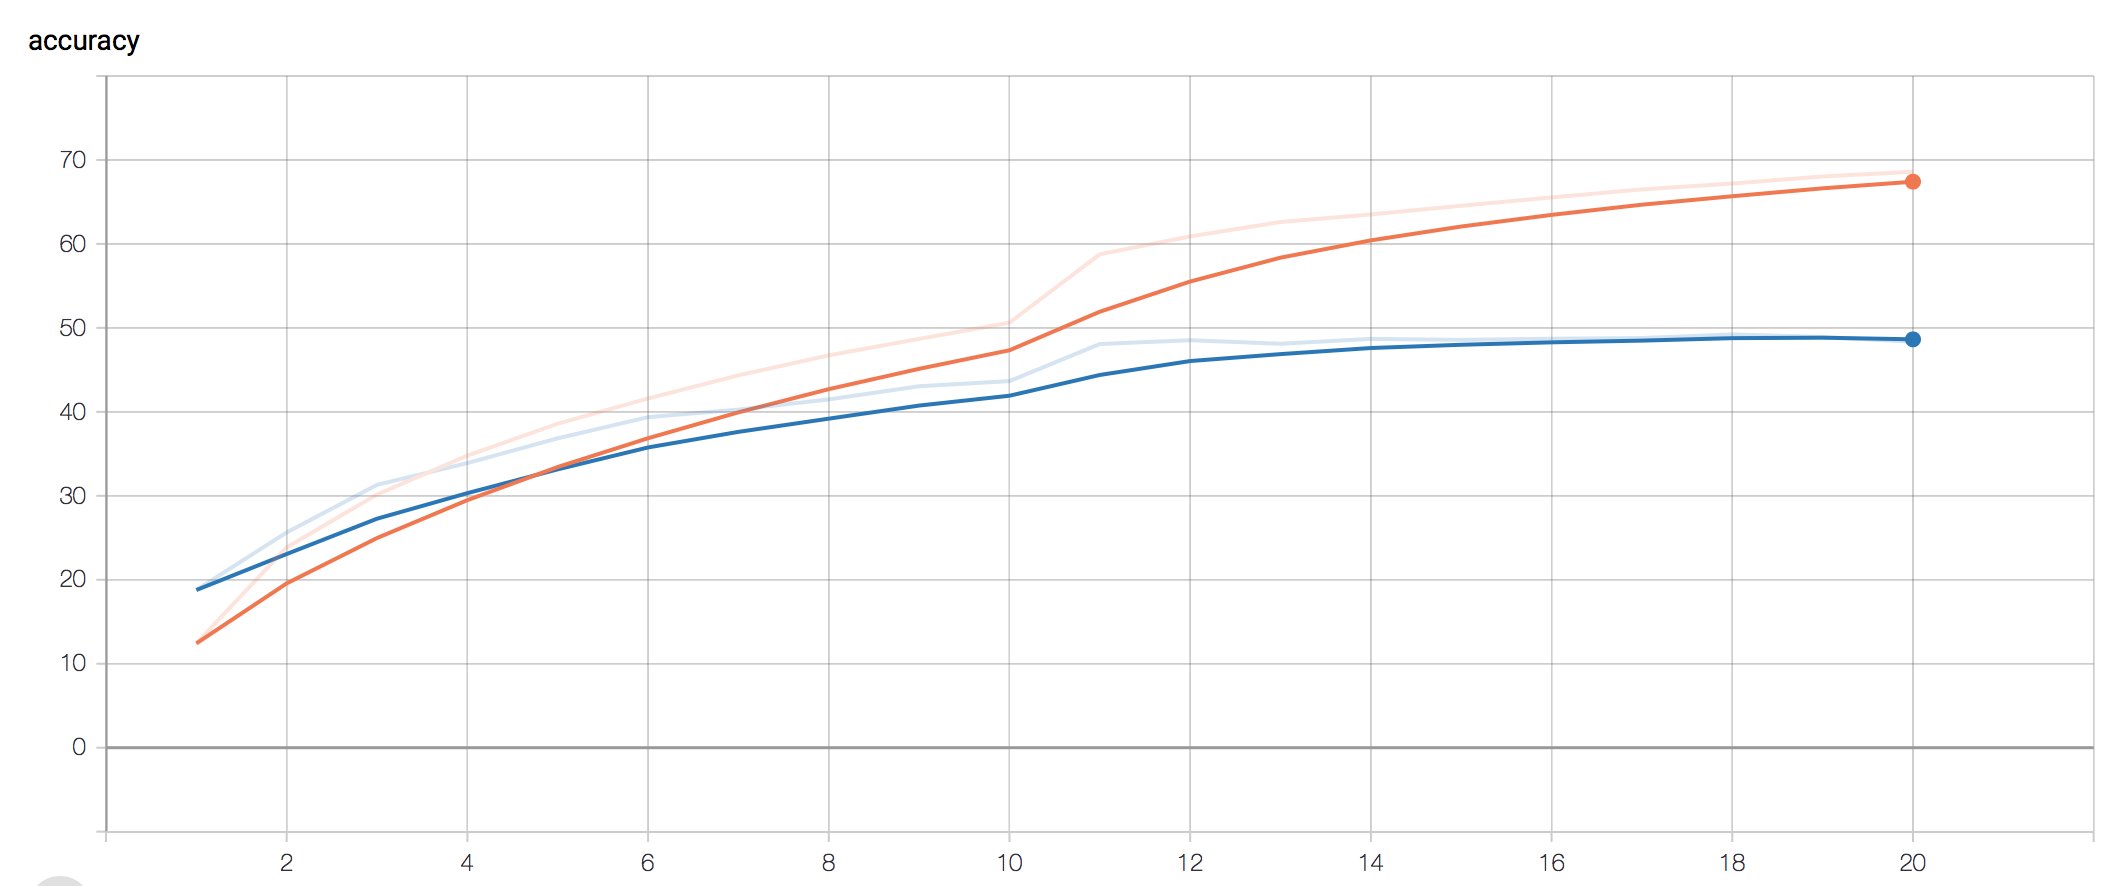

In [0]:
from IPython.display import Image
Image('loss.png')

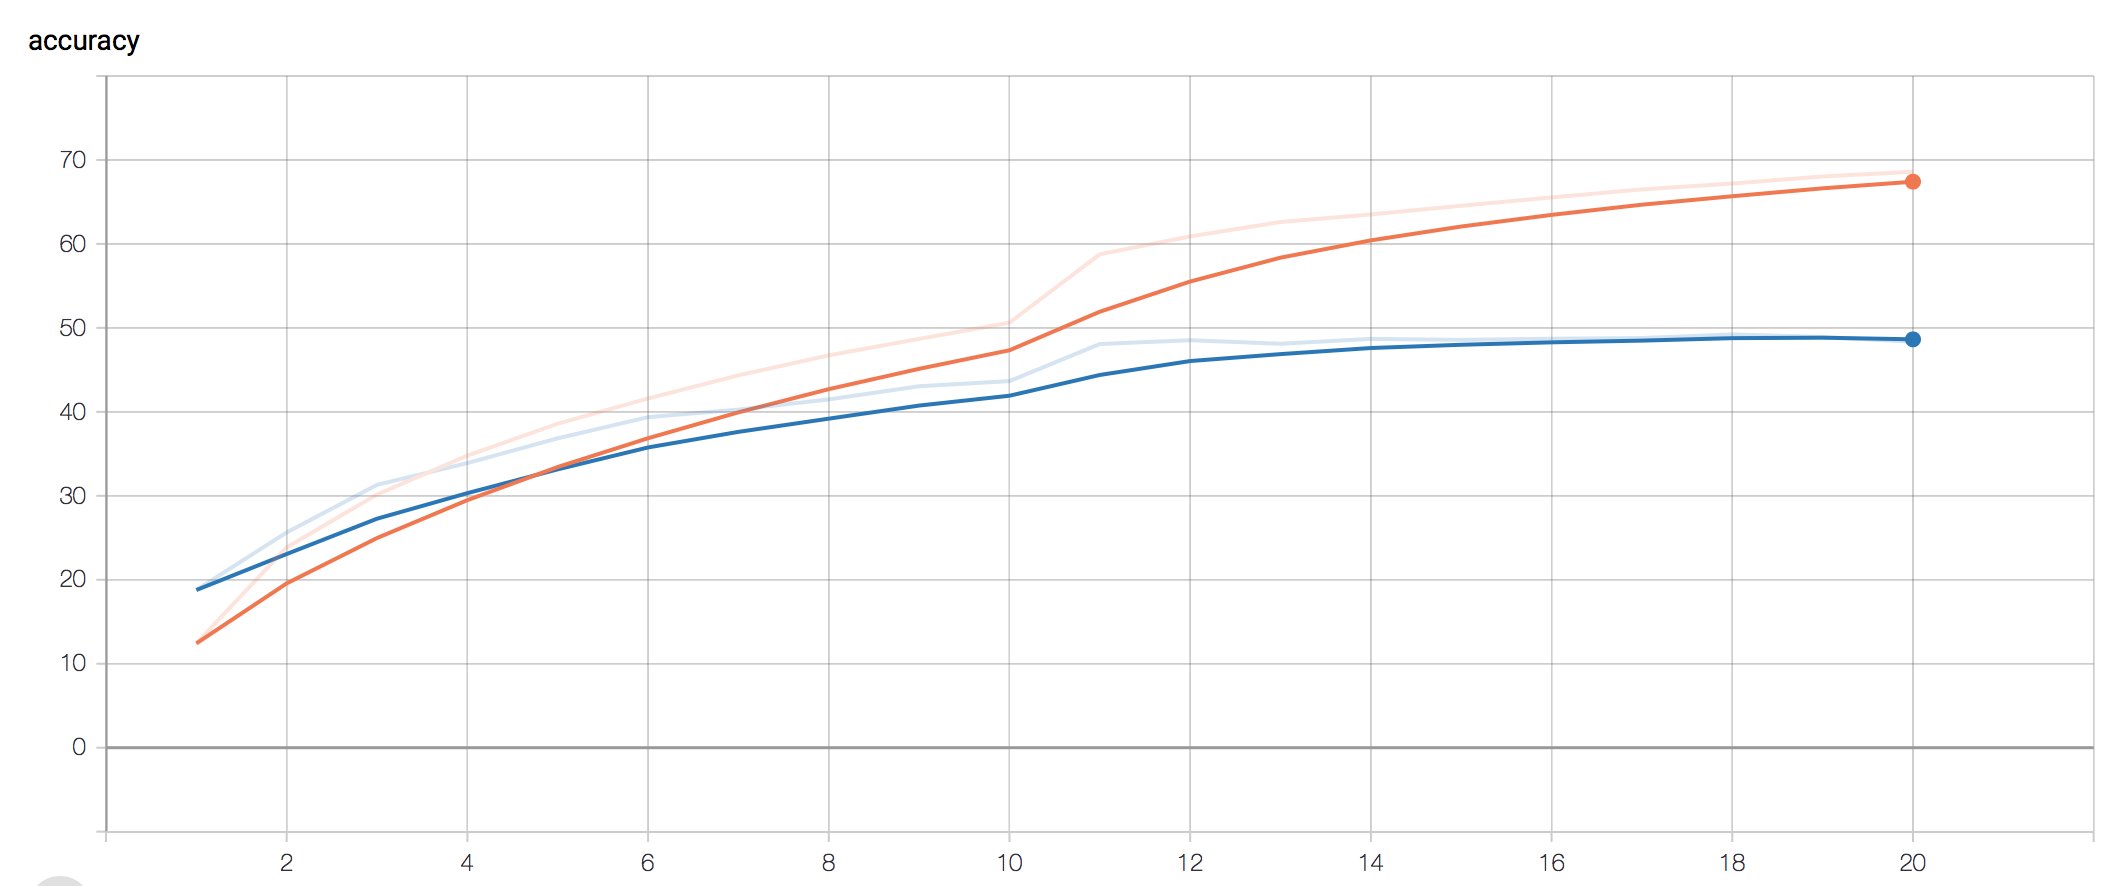

In [0]:
Image('accuracy.png')